In [225]:
import numpy as np
import pkg_resources
import pickle
import matplotlib.pyplot as plt
from pathlib import Path
from flygym.envs.nmf_mujoco import NeuroMechFlyMuJoCo, MuJoCoParameters
from tqdm import trange
from flygym.util.config import all_leg_dofs
from flygym.state import stretched_pose, walking_pose

from flygym.arena.mujoco_arena import MixedTerrain, BlocksTerrain, GappedTerrain, FlatTerrain, Tethered

from flygym.util.cpg_controller import (
    advancement_transfer,
    phase_oscillator,
    initialize_solver,
    phase_biases_tripod_idealized,
    plot_phase_amp_output,
    sine_output,
)

from tqdm import trange
import cv2

# Use thetered fly to build a dataset of leg lifting for each leg

In [226]:
# Initialize simulation
run_time = 1.0

cs_placements = all_tarsi_links = [
    f"{side}{pos}Tarsus{i}" for side in "LR" for pos in "FMH" for i in range(1, 6)
]
cs_placements += [f"{side}{pos}Tibia" for side in "LR" for pos in "FMH"]


sim_params = MuJoCoParameters(timestep=1e-4, render_mode="saved", render_playspeed=0.001, render_camera="Animat/camera_left_top_zoomout",
                               enable_adhesion=True, draw_adhesion=True, draw_contacts=False, adhesion_gain=20, actuator_kp=30, adhesion_off_duration = 0.03
                               )

In [227]:
arena = Tethered()


nmf = NeuroMechFlyMuJoCo(
    sim_params=sim_params,
    init_pose=walking_pose,
    actuated_joints=all_leg_dofs,
    arena = arena,
    
)

In [228]:
obs, info = nmf.reset()
base_angles = obs["joints"][0]

joint_angles_modif = []
obs_list = []

joint_angles = base_angles.copy()

legs =  [lts[:2] for lts in nmf.last_tarsalseg_names]
joints_in_leg = [[i for i, joint in enumerate(nmf.actuated_joints) if leg in joint] for leg in legs]
joint_name_to_id = {joint[8:]: i for i, joint in enumerate(nmf.actuated_joints[:len(joints_in_leg[0])])}

raise_leg = np.zeros((len(legs), 42))
for i, leg in enumerate(legs):
    if "F" in leg:
        raise_leg[i, joints_in_leg[i][joint_name_to_id["Femur"]]] = -0.02
        raise_leg[i, joints_in_leg[i][joint_name_to_id["Tibia"]]] = +0.016
    elif "M" in leg:
        raise_leg[i, joints_in_leg[i][joint_name_to_id["Coxa"]]] = -0.015
        raise_leg[i, joints_in_leg[i][joint_name_to_id["Femur"]]] = 0.004
        raise_leg[i, joints_in_leg[i][joint_name_to_id["Tibia"]]] = 0.01
        raise_leg[i, joints_in_leg[i][joint_name_to_id["Tarsus1"]]] = -0.008
        raise_leg[i, joints_in_leg[i]] *= 1.2
    elif "H" in leg:
        raise_leg[i, joints_in_leg[i][joint_name_to_id["Femur"]]] = -0.01
        raise_leg[i, joints_in_leg[i][joint_name_to_id["Tibia"]]] = +0.005
        

for l, leg in enumerate(legs):
    for i in range(100):
        joint_angles = base_angles.copy() + raise_leg[l]*i

        action = {"joints": joint_angles, "adhesion": np.zeros(6)}

        obs, _, _, _, _ = nmf.step(action)
        obs_list.append(obs)
        render_status = nmf.render()
        if render_status:
            #indicate legs
            cv2.putText(nmf.get_last_frame(), leg, (10, 50), 0, 1, (0, 255, 0), 2)
    for i in range(-50, 0):
        joint_angles -= 2*raise_leg[l]
        action = {"joints": joint_angles, "adhesion": np.zeros(6)}

        obs, _, _, _, _ = nmf.step(action)
        obs_list.append(obs)
        render_status = nmf.render()
        if render_status:
            #indicate legs
            cv2.putText(nmf.get_last_frame(), leg, (10, 50), 0, 1, (0, 255, 0), 2)
    for i in range(10):
        # do nothing
        action = {"joints": joint_angles, "adhesion": np.zeros(6)}
        obs, _, _, _, _ = nmf.step(action)
        obs_list.append(obs)
        render_status = nmf.render()

In [229]:
video_path = Path('hybrid_control/raise_legs.mp4')
nmf.save_video(video_path, 0)

from ipywidgets import Video
Video.from_file(video_path)

Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free...')

In [230]:
# plot end effector trajectory
"""end_effector_pos = np.array([obs["end_effectors"] for obs in obs_list]).reshape(-1, 6,3)
fig, axs = plt.subplots(len(nmf.last_tarsalseg_names), figsize=(15, 15))

for i, end_effector in enumerate(nmf.last_tarsalseg_names):
    axs[i].plot(end_effector_pos[:, i, 0], label=end_effector+"_x")
    axs[i].plot(end_effector_pos[:, i, 1], label=end_effector+"_y")
    axs[i].plot(end_effector_pos[:, i, 2], label=end_effector+"_z")
    axs[i].legend()
plt.tight_layout()"""

'end_effector_pos = np.array([obs["end_effectors"] for obs in obs_list]).reshape(-1, 6,3)\nfig, axs = plt.subplots(len(nmf.last_tarsalseg_names), figsize=(15, 15))\n\nfor i, end_effector in enumerate(nmf.last_tarsalseg_names):\n    axs[i].plot(end_effector_pos[:, i, 0], label=end_effector+"_x")\n    axs[i].plot(end_effector_pos[:, i, 1], label=end_effector+"_y")\n    axs[i].plot(end_effector_pos[:, i, 2], label=end_effector+"_z")\n    axs[i].legend()\nplt.tight_layout()'

# Now real stuff

In [231]:
arena = FlatTerrain()
#arena = BlocksTerrain()
arena = GappedTerrain(gap_width=0.5)
#arena = MixedTerrain()

spawn0 = [0.0, 0.0, 0.5]

spawn1 = [2.3, 0.2, 0.5]
spawn2 = [0.0, 0.2, 0.5]
spawn3 = [0.8, -0.9, 0.5]
sim_params.render_playspeed = 0.1
sim_params.render_camera = "Animat/camera_left_top_zoomout"
sim_params.adhesion_gain = 40.0
nmf = NeuroMechFlyMuJoCo(
    sim_params=sim_params,
    init_pose=stretched_pose,
    actuated_joints=all_leg_dofs,
    arena = arena,
    spawn_pos = [1.85, -0.47, 0.3],
    #spawn_orient = [0, 0, np.pi/2],
    contact_sensor_placements=np.array(cs_placements),
    #camera_correction=False
)
num_steps_base = int(run_time / nmf.timestep)

In [232]:
# Load recorded data
data_path = Path(pkg_resources.resource_filename('flygym', 'data'))
with open(data_path / 'behavior' / 'single_steps.pkl', 'rb') as f:
    data = pickle.load(f)

In [233]:
# Interpolate 5x
step_duration = len(data['joint_LFCoxa'])
interp_step_duration = int(step_duration * data['meta']['timestep'] / nmf.timestep)
data_block = np.zeros((len(nmf.actuated_joints), interp_step_duration))
measure_t = np.arange(step_duration) * data['meta']['timestep']
interp_t = np.arange(interp_step_duration) * nmf.timestep
for i, joint in enumerate(nmf.actuated_joints):
    data_block[i, :] = np.interp(interp_t, measure_t, data[joint])

In [234]:
leg_swing_starts = {k:round(v/nmf.timestep) for k,v in data["swing_stance_time"]["swing"].items()}
leg_stance_starts = {k:round(v/nmf.timestep) for k,v in data["swing_stance_time"]["stance"].items()}

In [235]:
LEGS = ["RF", "RM", "RH", "LF", "LM", "LH"]

leg_ids = np.arange(len(LEGS)).astype(int)
leg_corresp_id = dict(zip(LEGS, leg_ids))
n_joints = len(nmf.actuated_joints)
joint_ids = np.arange(n_joints).astype(int)
match_leg_to_joints = np.array(
    [
        i
        for joint in nmf.actuated_joints
        for i, leg in enumerate(LEGS)
        if leg in joint
    ]
)

In [236]:
########### CONSTANTS ############
CONTROLLER_SEED = 42
N_STABILIZATION_STEPS = 2000
N_OSCILLATORS = len(LEGS)

COUPLING_STRENGTH = 10.0
AMP_RATES = 20.0
TARGET_AMPLITUDE = 1.0

frequencies = np.ones(N_OSCILLATORS) * 10

# For now each oscillator have the same amplitude
target_amplitudes = np.ones(N_OSCILLATORS) * TARGET_AMPLITUDE
rates = np.ones(N_OSCILLATORS) * AMP_RATES

phase_biases = phase_biases_tripod_idealized * 2 * np.pi
coupling_weights = (np.abs(phase_biases) > 0).astype(float) * COUPLING_STRENGTH

In [237]:
num_steps = N_STABILIZATION_STEPS + num_steps_base
 
# Initilize the simulation
np.random.seed(CONTROLLER_SEED)
start_ampl = np.ones(6) * 0.2

obs, _ = nmf.reset()

solver = initialize_solver(
    phase_oscillator,
    "dopri5",
    nmf.curr_time,
    N_OSCILLATORS,
    frequencies,
    coupling_weights,
    phase_biases,
    start_ampl,
    rates,
    int_params={"atol": 1e-6, "rtol": 1e-6, "max_step": 100000},
)
all_adhesions = []

joint_angles = np.zeros((num_steps, len(nmf.actuated_joints)))
adhesion_signal = np.zeros(6)
# Initalize storage
obs_list = []
phases = np.zeros((num_steps, N_OSCILLATORS))
amplitudes = np.zeros((num_steps, N_OSCILLATORS))

all_indices = []
time = []

# Make the fly body transparent
leg_joint_names = ["Coxa", "Femur", "Tibia", "Tarsus1", "Tarsus2", "Tarsus3", "Tarsus4", "Tarsus5"]
for i_g in range(nmf.physics.model.ngeom): 
    geom = nmf.physics.model.geom(i_g)
    name = geom.name
    if not (name[9:-10] in leg_joint_names or name[9:-7] in leg_joint_names):
        geom.rgba[3] = 0.1
    if "groundblock" in name or "floor" in name:
        geom.rgba[3] = 1.0


joints_to_leg = np.array([i for ts in nmf.last_tarsalseg_names for i, joint in enumerate(nmf.actuated_joints) if f"{ts[:2]}Coxa_roll" in joint])
stance_starts_in_order = np.array([leg_stance_starts[ts[:2]] for ts in nmf.last_tarsalseg_names])
swing_starts_in_order = np.array([leg_swing_starts[ts[:2]] for ts in nmf.last_tarsalseg_names])
indices = np.zeros_like(nmf.actuated_joints, dtype=np.int64)

legs_in_hole = [False]*6
deepest_leg_in_hole = [False]*6
legs_in_hole_increment = np.zeros(6)      

# detect leg with "unatural" other than tarsus 4 or 5 contacts
leg_tarsus12T_contactsensors = [[i for i, cs in enumerate(nmf.contact_sensor_placements)
                                  if tarsal_seg[:2] in cs and ("Tibia" in cs or "Tarsus1" in cs or "Tarsus2" in cs)]
                                    for tarsal_seg in nmf.last_tarsalseg_names]
print(leg_tarsus12T_contactsensors)
force_threshold = -0.05
proximal_contact_leg = [False]*6
legs_w_proximalcontact_increment = np.zeros(6)

increase_rate_stumble = 1/5e-4*nmf.timestep #1 step every 200µs
decrease_rate_stumble = 1/2e-3*nmf.timestep

increase_rate_hole = 1/2.5e-3*nmf.timestep
decrease_rate_hole = 1/5e-3*nmf.timestep

legs_in_hole_increments = []
legs_w_proximalcontact_increments = []
joint_angle_increments = []
fly_orientations = []
last_tarsalseg_to_adh_id = [i for adh in nmf.adhesion_actuators for i, lts in enumerate(nmf.last_tarsalseg_names) if lts[:2] == adh.name[:2]]

to_floor_values = []
med_values = []
leg_to_thorax_zdistances = []

leg_in_stance = np.zeros(6)


force_diff = []


for i in trange(num_steps):

    if i > N_STABILIZATION_STEPS:
        # detect leg in gap show as blue tibia #only keep the deepest leg in the hole
        ee_z_pos = obs["end_effectors"][2::3]
        leg_to_thorax_zdistance = obs["fly"][0][2] - ee_z_pos
        # get the thrid leg distance (as tripod should be on the floor)
        third_furthest_leg = np.sort(leg_to_thorax_zdistance)[3]
        #print(np.sort(leg_to_thorax_zdistance))
        legs_in_hole = leg_to_thorax_zdistance > third_furthest_leg + 0.05
        
        #legs_in_hole = np.logical_and(legs_in_hole, leg_to_thorax_zdistance == np.max(leg_to_thorax_zdistance))
        #legs_in_hole = np.zeros(6, dtype=bool)
        for k, tarsal_seg in enumerate(nmf.last_tarsalseg_names):
            if legs_in_hole[k]:
                nmf.physics.named.model.geom_rgba["Animat/"+tarsal_seg[:2]+"Tibia_visual"] = [0.0, 0.0, 1.0, 1.0]
                legs_in_hole_increment[k] += increase_rate_hole
            else:
                nmf.physics.named.model.geom_rgba["Animat/"+tarsal_seg[:2]+"Tibia_visual"] = nmf.base_rgba
                if legs_in_hole_increment[k] > 0:
                    legs_in_hole_increment[k] -= decrease_rate_hole
        
        # detect leg with "unatural" other than tarsus 2, 3, 4 or 5 contacts and show as red Femur (Only look at force along negative x)

        fly_orient = obs["fly_orient"]
        fly_orient[2] = 0.0
        fly_orient_norm = np.linalg.norm(fly_orient)
        fly_orient_unit = fly_orient/fly_orient_norm
        # Look for forces opposing the fly orientation (and thus progression)
        for k, contact_sensors in enumerate(leg_tarsus12T_contactsensors):
            contact_forces = obs["contact_forces"][:, contact_sensors].T
            min_scalar_proj_contact_force = np.inf
            for contact_force in contact_forces:
                scalar_proj_force =  np.dot(contact_force, fly_orient_unit) #scalar_value
                min_scalar_proj_contact_force = min(min_scalar_proj_contact_force, scalar_proj_force)
            proximal_contact_leg[k] = np.logical_and(min_scalar_proj_contact_force < force_threshold, 
                                                     np.logical_not(leg_in_stance[k]))
    
        # look for the highest force        
        for k, tarsal_seg in enumerate(nmf.last_tarsalseg_names):
            if proximal_contact_leg[k] and not legs_in_hole[k]:
                nmf.physics.named.model.geom_rgba["Animat/"+tarsal_seg[:2]+"Femur_visual"] = [1.0, 0.0, 0.0, 1.0]
                legs_w_proximalcontact_increment[k] += increase_rate_stumble
            else:
                nmf.physics.named.model.geom_rgba["Animat/"+tarsal_seg[:2]+"Femur_visual"] = nmf.base_rgba
                if legs_w_proximalcontact_increment[k] > 0:
                    legs_w_proximalcontact_increment[k] -= decrease_rate_stumble
    
    joint_angle_increment =(raise_leg.T*legs_in_hole_increment).sum(axis=1) + (raise_leg.T*legs_w_proximalcontact_increment).sum(axis=1)
    joint_angle_increments.append(joint_angle_increment.copy())

    legs_in_hole_increments.append(legs_in_hole_increment.copy())
    legs_w_proximalcontact_increments.append(legs_w_proximalcontact_increment.copy())

    # Only step the solver if there is no need for paralysis
    # if the leg is stuck: leg_tarsus12T_accumulator > accumulator_threshold
    # All other legs are kept paralyzed phase is constant
    # The stuck leg increases its phase by 2*np.pi/interp_step_duration (should be two steps)
    res = solver.integrate(nmf.curr_time)
    phase = res[:N_OSCILLATORS]
    amp = res[N_OSCILLATORS : 2 * N_OSCILLATORS]

    phases[i, :] = phase
    amplitudes[i, :] = amp    

    if i == N_STABILIZATION_STEPS:
        # Now set the amplitude to their real values
        solver.set_f_params(
            N_OSCILLATORS,
            frequencies,
            coupling_weights,
            phase_biases,
            target_amplitudes,
            rates,
        )
    if i > N_STABILIZATION_STEPS:
        indices = advancement_transfer(
            phase, interp_step_duration, match_leg_to_joints
        )
        all_indices.append(indices)

        # scale amplitude by interpolating between the resting values and i timestep value
        input_joint_angles = (
            data_block[joint_ids, 0]
            + (data_block[joint_ids, indices] - data_block[joint_ids, 0])
            * amp[match_leg_to_joints]
        )
    else:
        input_joint_angles = data_block[joint_ids, 0]
    
    input_joint_angles = input_joint_angles + joint_angle_increment
    joint_angles[i, :] = input_joint_angles
    leg_in_stance = np.logical_or(indices[joints_to_leg] < swing_starts_in_order,
                                         indices[joints_to_leg] > stance_starts_in_order)
    adhesion_signal = leg_in_stance
    adhesion_signal[np.logical_or(legs_in_hole, proximal_contact_leg)[last_tarsalseg_to_adh_id]] = 0.0
    all_adhesions.append(adhesion_signal)

    action = {"joints": input_joint_angles, "adhesion": adhesion_signal}

    obs, _, _, _, _ = nmf.step(action)
    obs_list.append(obs)
    render_status = nmf.render()

    time.append(nmf.curr_time)

    if render_status:
        # write current time on frame
        cv2.putText(nmf.get_last_frame(), f"{nmf.curr_time:.2f}", (10, 50), 0, 1, (0, 255, 0), 2)

[[0, 1, 30], [5, 6, 31], [10, 11, 32], [15, 16, 33], [20, 21, 34], [25, 26, 35]]


100%|██████████| 12000/12000 [00:35<00:00, 335.98it/s]


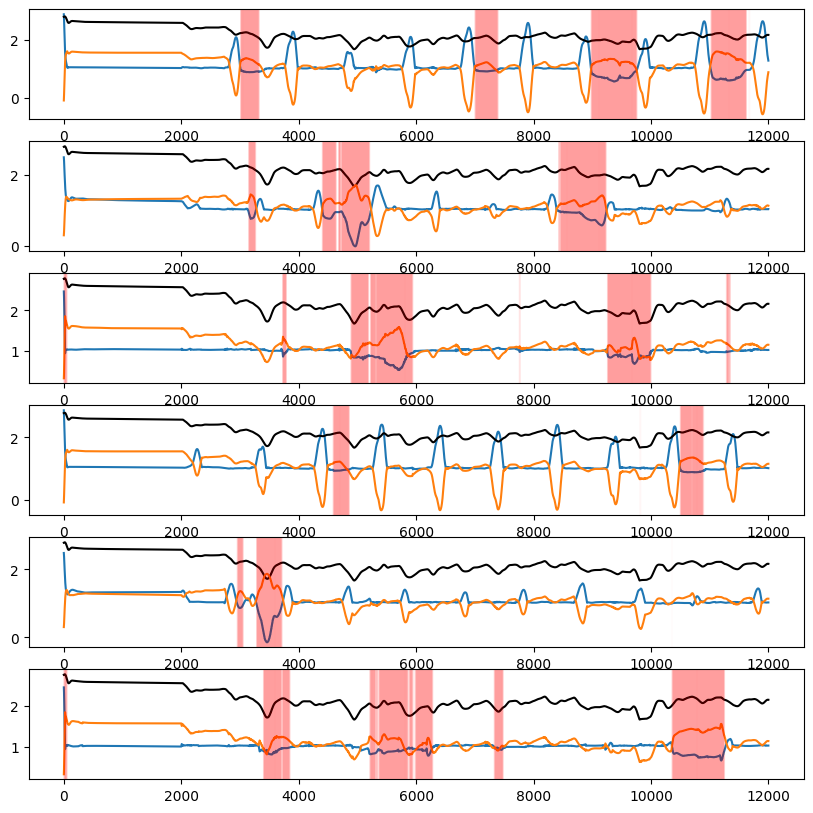

In [238]:
end_effector_z = np.array([obs["end_effectors"][2::3] for obs in obs_list])
fly_zpos = np.array([obs["fly"][0][2] for obs in obs_list])

proprioceptive_signal = fly_zpos[:, np.newaxis] - end_effector_z

#third_furthest_leg = proprioceptive_signal[np.arange(12000), np.argpartition(proprioceptive_signal, 1, axis=1)[:, 0]]
third_furthest_leg = np.sort(proprioceptive_signal, axis=1)[:, 3]
#furthest_leg = np.max(proprioceptive_signal, axis=1)-0.1

fig, axs = plt.subplots(6, 1, figsize=(10, 10))

for i in range(6):
    axs[i].plot(end_effector_z[:, i], label=nmf.last_tarsalseg_names[i])
    axs[i].plot(fly_zpos, "k", label="fly_zpos")
    axs[i].plot(proprioceptive_signal[:, i], label="zpos diff")

    inferior_third_lowest_leg = proprioceptive_signal[:, i] > third_furthest_leg + 0.05
    for j in np.where(inferior_third_lowest_leg)[0]:
        axs[i].axvline(j, color="r", alpha=0.01)

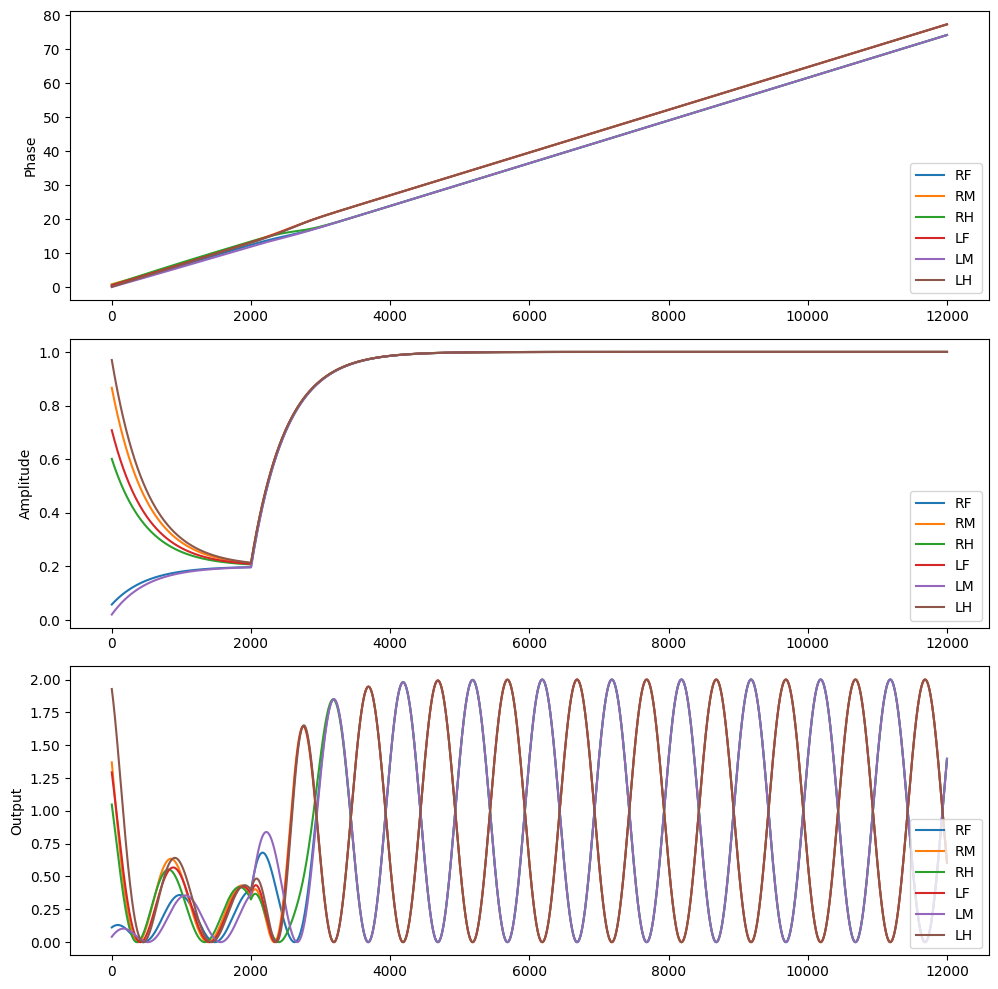

In [239]:
plot_phase_amp_output(phases, amplitudes, sine_output(phases, amplitudes), LEGS)

In [240]:
video_path = Path('hybrid_control/video.mp4')
nmf.save_video(video_path, 0)

from ipywidgets import Video
Video.from_file(video_path)

Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free...')

-0.145461276713641
-0.145461276713641
-0.145461276713641
-0.012088984881667736
-0.012088984881667736
-0.012088984881667736


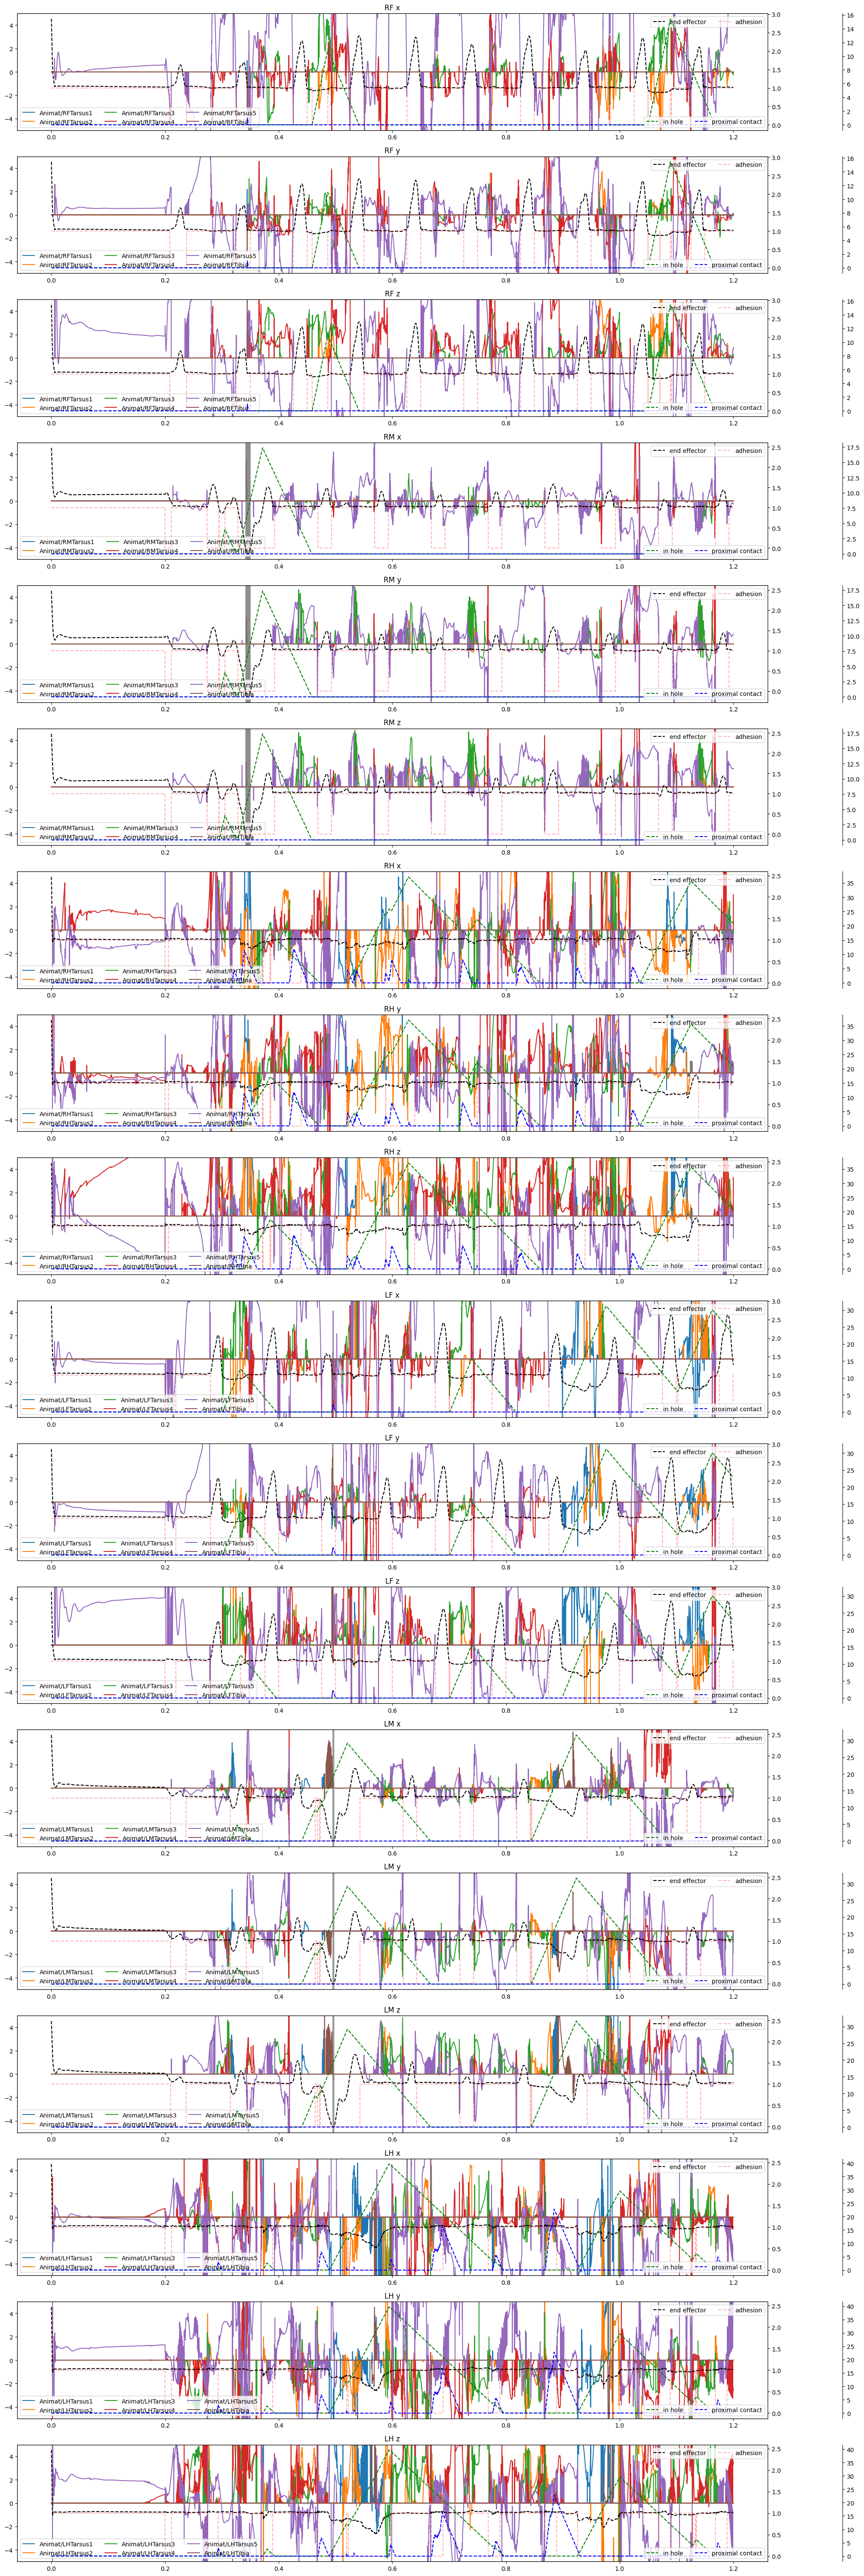

In [241]:
from scipy.signal import medfilt
contact_forces = np.array([obs['contact_forces'] for obs in obs_list])
end_effector_pos = np.array([obs['end_effectors'] for obs in obs_list]).reshape(-1, 6, 3)
end_effector_sensors_names = [ee.name[:-4] for ee in nmf.end_effector_sensors]

adhesion_actuator_names = [adh_act.name[:-9] for adh_act in nmf.adhesion_actuators]
all_adhesions = np.array(all_adhesions)

legs_in_hole_increments = np.array(legs_in_hole_increments)
legs_w_proximalcontact_increments = np.array(legs_w_proximalcontact_increments)

filter_window = (11, 1)

fig, axs  = plt.subplots(3*6, 1, figsize=(20, 60))
for j, leg in enumerate(LEGS):
    c_ids = [i for i, c in enumerate(nmf.contact_sensor_placements) if leg in c]
    contact_sensors = np.array(nmf.contact_sensor_placements)[c_ids]
    ee_i = end_effector_sensors_names.index(leg+"Tarsus5")
    i_adh = [i for i, adh in enumerate(adhesion_actuator_names) if leg in adh]
    for i, coord in enumerate(["x", "y", "z"]):
        #filt_c = medfilt(contact_forces[:, i, c_ids], filter_window)
        axs[3*j+i].plot(time, contact_forces[:, i, c_ids])
        axs[3*j+i].set_title(f'{leg} {coord}')
        axs[3*j+i].legend(contact_sensors, loc="lower left", ncols=3,)
        axs[3*j+i].set_ylim([-5, 5])
        twin_ax = axs[3*j+i].twinx()
        twin_ax.plot(time, end_effector_pos[:, ee_i, -1], 'k--', label='end effector')
        twin_ax.plot(time, all_adhesions[:, i_adh], "--", color = "red", label="adhesion", alpha=0.3)
        twin_ax.legend(loc="upper right", ncol=2)

        twin_ax2 = axs[3*j+i].twinx()
        twin_ax2.plot(time, legs_in_hole_increments[:, ee_i], "--", color = "green", label="in hole")
        twin_ax2.plot(time, legs_w_proximalcontact_increments[:, ee_i], "--", color = "blue", label="proximal contact")
        twin_ax2.legend(loc="lower right", ncol=2)
        twin_ax2.spines["right"].set_position(("axes", 1.1))
        # draw v line with low alpha if ee_pos < 0
        ids = np.where(end_effector_pos[:, ee_i, -1] < 0)[0]
        for id in ids:
            axs[3*j+i].axvline(x=time[id], color="grey", alpha=0.1)
        if np.size(ids) > 0:
            print(np.min(end_effector_pos[ids, ee_i, -1]))

plt.tight_layout()

# Show difference in hight between z pos and Thorax and zpos itself

In [242]:
video_path = Path('hybrid_control/video.mp4')
nmf.save_video(video_path, 0)

from ipywidgets import Video
Video.from_file(video_path)

Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free...')

ValueError: x and y must have same first dimension, but have shapes (12000,) and (0,)

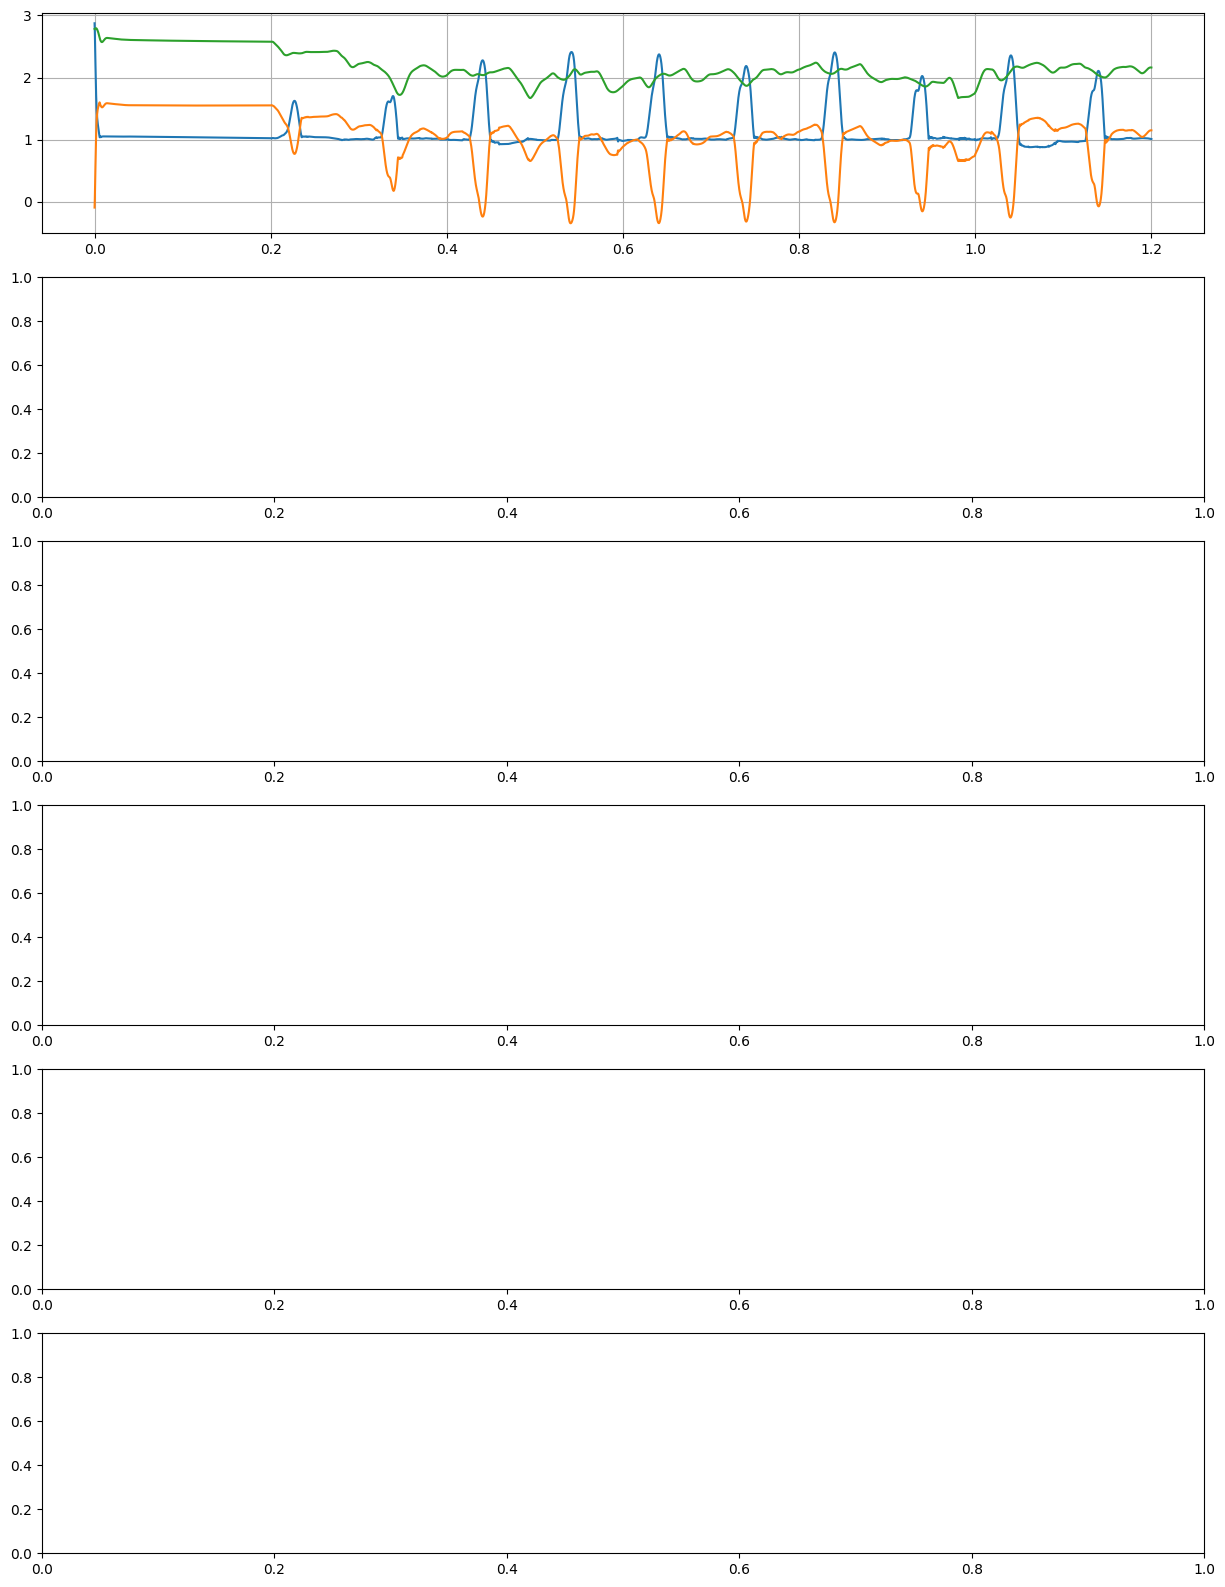

In [243]:
from scipy.signal import medfilt
contact_forces = np.array([obs['contact_forces'] for obs in obs_list])
end_effector_pos = np.array([obs['end_effectors'] for obs in obs_list]).reshape(-1, 6, 3)
end_effector_sensors_names = [ee.name[:-4] for ee in nmf.end_effector_sensors]

fly_pos = np.array([obs['fly'][0] for obs in obs_list])
fly_vel = np.array([obs['fly'][1] for obs in obs_list])

all_proprioception_signals = np.expand_dims(fly_pos[:, 2], axis=-1)- end_effector_pos[:, :, 2]

time = np.arange(num_steps) * nmf.timestep


fig, axs  = plt.subplots(6, 1, figsize=(15, 20))
for j, leg in enumerate(LEGS):
    c_ids = [i for i, c in enumerate(nmf.contact_sensor_placements) if leg in c]
    contact_sensors = np.array(nmf.contact_sensor_placements)[c_ids]
    ee_i = end_effector_sensors_names.index(leg+"Tarsus5")
    i_adh = [i for i, adh in enumerate(adhesion_actuator_names) if leg in adh]
    # plot end effecor z position
    axs[j].plot(time, end_effector_pos[:, ee_i, 2], label="end effector z pos")
    # plot difference between end effector and fly z position
    axs[j].plot(time, all_proprioception_signals[:, ee_i], label="fly - end effector z pos")
    axs[j].plot(time, fly_pos[:, 2], label="fly z pos")
    axs[j].grid()

    """tax = axs[j].twinx()
    tax.plot(time, np.sign(fly_vel[:, 2]), label="fly z vel sign", color="r")
    tax.legend(loc="lower right")"""

    # plot median for all legs vs median for the leg of the difference
    #leg_median = np.median(fly_pos[:, 2] - end_effector_pos[:, ee_i, 2])
    #all_legs_median = np.median(all_proprioception_signals[:, ee_i])
    #axs[j].axhline(leg_median, color="k", linestyle="--", label="median for leg")
    #axs[j].axhline(all_legs_median, color="r", linestyle="--", label="median for all legs")
    
    axs[j].plot(time[-len(med_values):], med_values, label="median for all legs")

    #axs[j].plot(time[-len(med_values):], np.std(all_proprioception_signals[-len(med_values):, :], axis=1), label="std for all legs")
    min_prop_sig = np.quantile(all_proprioception_signals[-len(med_values):, :], 0.3, axis=1)
    max_prop_sig = np.quantile(all_proprioception_signals[-len(med_values):, :], 0.7, axis=1)
    axs[j].plot(time[-len(med_values):], max_prop_sig - min_prop_sig, label="min/max for all legs")
    

    """ids = np.where(all_proprioception_signals[-len(med_values):, ee_i] > np.array(med_values)+0.1)[0]
    for id in ids:
        axs[j].axvline(x=time[-len(med_values):][id], color="grey", alpha=0.1)
    if np.size(ids) > 0:
        print(np.min(end_effector_pos[ids, ee_i, -1]))"""
    
    axs[j].legend()
    axs[j].set_title(leg)

plt.tight_layout()

In [ ]:
leg_to_thorax_zdistance, 

(array([-1.40247212, -1.13390566, -1.4733091 , -1.32314485, -0.30616058,
        -1.28785994]),)

# Theter the fly again and look at the increment only generated movements

In [ ]:
arena = Tethered()

nmf_th = NeuroMechFlyMuJoCo(
    sim_params=sim_params,
    init_pose=stretched_pose,
    actuated_joints=all_leg_dofs,
    arena = arena,
)

In [ ]:
base_angles = data_block[:, 0]
for joint_angle in joint_angle_increments:
    action = {"joints": base_angles + joint_angle, "adhesion": adhesion_signal}
    obs_th, _, _, _, _ = nmf_th.step(action)
    _ = nmf_th.render()


In [ ]:
# get video of the short clip 
video_path = Path('hybrid_control/angle_increments.mp4')
nmf_th.save_video(video_path, 0)

from ipywidgets import Video
Video.from_file(video_path)

Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free...')

In [ ]:
forelegs_ids = [id for id, tarsal_seg in enumerate(nmf.last_tarsalseg_names) if tarsal_seg[:2].endswith("F")]